In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support
import cf_matrix as cf 
from collections import Counter
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [74]:
#functions
def feature_importance(estimator, ax, title):
    
    feat_importances = pd.Series(estimator.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh', ax=ax)
    plt.title(title,fontweight='bold')

def col_transformed(df,col):
    df_temp=df.copy()
    enc=preprocessing.LabelEncoder()
    enc=enc.fit(df_temp[col])
    df_temp[col]=enc.transform(df_temp[col])
    df=df_temp
    return df

def prec_re(y_test, y_pred, classifier):
    ps,rs,fs,ss=precision_recall_fscore_support(y_test, y_pred, average=None,labels=[0,1,2])
    df=pd.DataFrame({'precision': ps, 'recall': rs, 'f-score': fs, 'sample_size': ss})
    return df.style.set_caption("Precision-Recall -"+ classifier).\
        format({'precision': "{:.2}", 'recall': "{:.2}", 'f-score': "{:.2}" })

def adop_user_tag(num):
    if num >=3:
        return 'Adopted_User'
    elif (num < 3 and num >=1):
        return 'Once_or_Twice_Logged_In'
    else:
        return 'Never_Logged_In'

In [3]:
#All the data about users who signed up
df_users=pd.read_csv('takehome_users.csv', encoding='latin1', parse_dates=['creation_time'])

In [4]:
df_users.rename(columns={'object_id':'user_id'},inplace=True)

In [5]:
#The data of  users' logging history
df_user_eng = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])

In [6]:
#Changing unix times in last_session_created_time to pandas datatime type
df_users['last_session_creation_time']=(pd.to_datetime(df_users['last_session_creation_time'],unit='s'))

In [7]:
#df_users.info()

In [8]:
#df_users.head(5)

In [9]:
#df_user_eng.info()

In [10]:
#df_user_eng.head(5)

In [11]:
#df_user_eng['time_stamp'].max() 
#Timestamp('2014-06-06 14:58:50')

In [12]:
#df_user_eng['time_stamp'].min()
#Timestamp('2012-05-31 08:20:06')

In [13]:
### The data goes from 2012-05-31 to 2014-06-06

### Objective: 
What factors makes a user an 'adopted user'?

An 'adopted user' is the one who connects to Relax Inc at least 3 days a week

By examing the data of 'adopted users', can we predict factors that makes a user an 'adopted user'?

In [14]:
df_user_eng['year']=df_user_eng['time_stamp'].dt.year
df_user_eng['month']=df_user_eng['time_stamp'].dt.month
df_user_eng['day']=df_user_eng['time_stamp'].dt.day
df_user_eng['week']=df_user_eng['time_stamp'].dt.week

df_user_eng.drop(['time_stamp'],axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [15]:
df_adp_user=df_user_eng.groupby(['user_id','year','week']).agg({'visited':'count'}).reset_index()
#df_adp_user

In [16]:
#True Adopted Users i.e. they visited >=3 times in any perioed of 7 days
df_adpoted_user=df_adp_user[df_adp_user.visited >=3].reset_index(drop=True)
#df_adpoted_user.info()    #33816 rows

In [17]:
#Users that have visited < 3 times 
df_non_adp_user=df_adp_user[df_adp_user.visited <3].reset_index(drop=True)
#df_non_adp_user.info() #35461

In [18]:
df_adpoted_user_unique=df_adpoted_user.groupby(['user_id']).agg({'visited':'max'})
df_adpoted_user_unique['user_id_unique']=df_adpoted_user_unique.index
df_adpoted_user_unique.reset_index(drop=True, inplace=True)
df_adpoted_user_unique.rename({'user_id_unique':'user_id'}, axis=1,inplace=True)

In [19]:
df_non_adp_user_unique=df_non_adp_user.groupby(['user_id']).agg({'visited':'max'})
df_non_adp_user_unique['user_id_unique']=df_non_adp_user_unique.index
df_non_adp_user_unique.reset_index(drop=True, inplace=True)
df_non_adp_user_unique.rename({'user_id_unique':'user_id'}, axis=1,inplace=True)

In [20]:
df_non_adp_user_unique.sort_values(by='user_id').head()

,visited,user_id
0,1,1
1,2,2
2,1,3
3,1,4
4,1,5


In [21]:
df_combine_unq_users=pd.merge(df_adpoted_user_unique,df_non_adp_user_unique,how='outer',on='user_id')

In [22]:
df_combine_unq_users.fillna(0,inplace=True)

In [23]:
df_combine_unq_users['visited'] = df_combine_unq_users.apply(lambda z: max(z['visited_x'], z['visited_y']), axis=1)
df_combine_unq_users.drop(['visited_x','visited_y'], axis=1,inplace=True)

In [24]:
#df_combine_unq_users contains all the users with their number of visits per year per week

In [25]:
#concat the df_users with df_combined_unq_users on left as we want to keep all the rows of df_users

In [26]:
df_adp_unq_with_eng=pd.merge(df_users,df_combine_unq_users,how='left',on='user_id')

In [27]:
df_adp_unq_with_eng['visited'].fillna(0,inplace=True)

In [28]:
df_adp_unq_with_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  visited                     12000 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)


In [29]:
df_adp_unq_with_eng['adopted_user_level']=df_adp_unq_with_eng.apply(lambda x: adop_user_tag(x['visited']), axis=1)

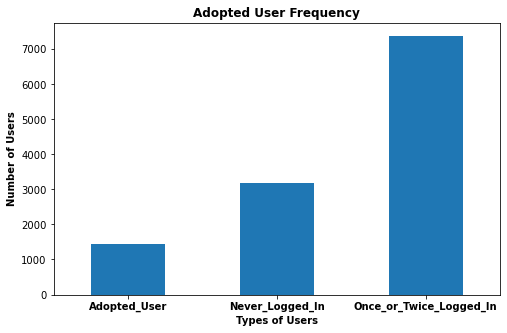

In [30]:
plt.figure(figsize=(8,5))
df_adp_unq_with_eng.groupby(['adopted_user_level'])['adopted_user_level'].count().plot.bar()
plt.xlabel('Types of Users',fontweight='bold')
plt.xticks(rotation=0,fontweight='bold')
plt.ylabel('Number of Users',fontweight='bold')
plt.title('Adopted User Frequency',fontweight='bold')
plt.savefig('Types_Users_Distribution')

In [31]:
df_adp_unq_with_eng['creation_hour']=df_adp_unq_with_eng.creation_time.dt.hour
df_adp_unq_with_eng['creation_month']=df_adp_unq_with_eng.creation_time.dt.month

In [32]:
df=df_adp_unq_with_eng.groupby(['creation_source','adopted_user_level']).agg({'adopted_user_level':'count'}).rename({'adopted_user_level':'count_of_users'},axis=1).reset_index()

<Figure size 720x360 with 0 Axes>

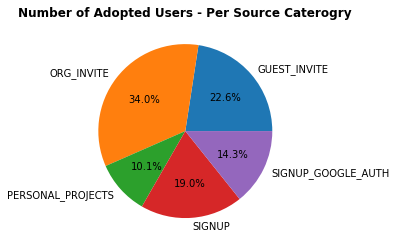

In [33]:
plt.figure(figsize=(10,5))
(df[df.adopted_user_level=='Adopted_User'][['creation_source','count_of_users']]).set_index('creation_source').plot.pie(y='count_of_users',ylabel='',legend=False,\
                   autopct='%1.1f%%')

plt.title("Number of Adopted Users - Per Source Caterogry", fontweight='bold')
plt.tight_layout
plt.savefig('pie_chart_adapted_users_per_cat.jpg')

<Figure size 720x360 with 0 Axes>

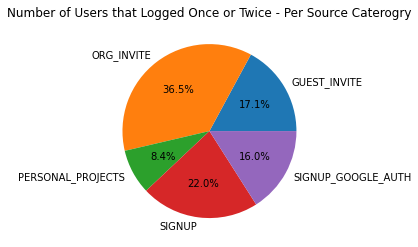

In [34]:
plt.figure(figsize=(10,5))
(df[df.adopted_user_level=='Once_or_Twice_Logged_In'][['creation_source','count_of_users']]).set_index('creation_source').plot.pie(y='count_of_users',ylabel='',legend=False,\
                   autopct='%1.1f%%')
plt.title("Number of Users that Logged Once or Twice - Per Source Caterogry")
plt.tight_layout
plt.savefig('pie_chart_once_or_twice_logged_per_cat.jpg')

<Figure size 720x360 with 0 Axes>

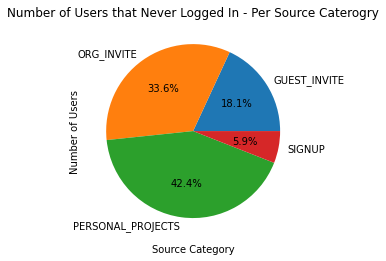

In [35]:
plt.figure(figsize=(10,5))
(df[df.adopted_user_level=='Never_Logged_In'][['creation_source','count_of_users']]).set_index('creation_source').plot.pie(y='count_of_users',ylabel='',legend=False,\
                   autopct='%1.1f%%')
plt.xlabel('Source Category')
plt.ylabel('Number of Users')
plt.title("Number of Users that Never Logged In - Per Source Caterogry")
plt.tight_layout
plt.savefig('pie_chart_never_logged_in_per_cat.jpg')

In [36]:
df_m=df_adp_unq_with_eng.groupby(['creation_month','adopted_user_level']).agg({'adopted_user_level':'count'}).rename({'adopted_user_level':'count_of_users'},axis=1).reset_index()

<Figure size 720x360 with 0 Axes>

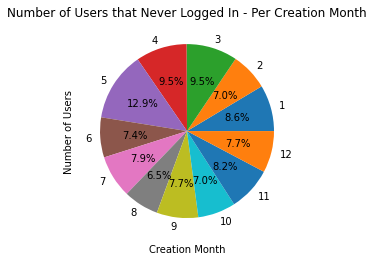

In [37]:
plt.figure(figsize=(10,5))
(df_m[df_m.adopted_user_level=='Never_Logged_In'][['creation_month','count_of_users']]).set_index('creation_month').plot.pie(y='count_of_users',ylabel='',legend=False,\
                   autopct='%1.1f%%')
plt.xlabel('Creation Month')
plt.ylabel('Number of Users')
plt.title("Number of Users that Never Logged In - Per Creation Month")
plt.tight_layout
plt.savefig('pie_chart_never_logged_in_per_month.jpg')

<Figure size 720x360 with 0 Axes>

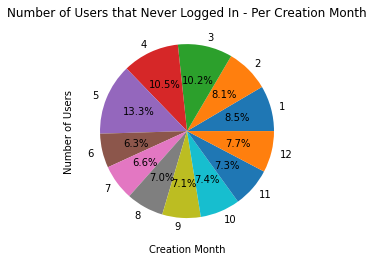

In [38]:
plt.figure(figsize=(10,5))
(df_m[df_m.adopted_user_level=='Once_or_Twice_Logged_In'][['creation_month','count_of_users']]).set_index('creation_month').plot.pie(y='count_of_users',ylabel='',legend=False,\
                   autopct='%1.1f%%')
plt.xlabel('Creation Month')
plt.ylabel('Number of Users')
plt.title("Number of Users that Never Logged In - Per Creation Month")
plt.tight_layout
plt.savefig('pie_chart_onceortwice_logged_in_per_month.jpg')

<Figure size 720x360 with 0 Axes>

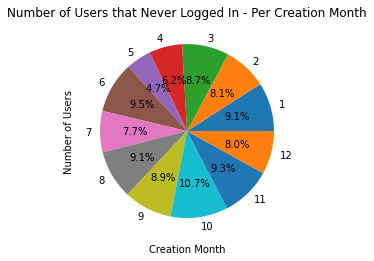

In [39]:
plt.figure(figsize=(10,5))
(df_m[df_m.adopted_user_level=='Adopted_User'][['creation_month','count_of_users']]).set_index('creation_month').plot.pie(y='count_of_users',ylabel='',legend=False,\
                   autopct='%1.1f%%')
plt.xlabel('Creation Month')
plt.ylabel('Number of Users')
plt.title("Number of Users that Never Logged In - Per Creation Month")
plt.tight_layout
plt.savefig('pie_chart_Adopted_User_per_month.jpg')

<Figure size 720x576 with 0 Axes>

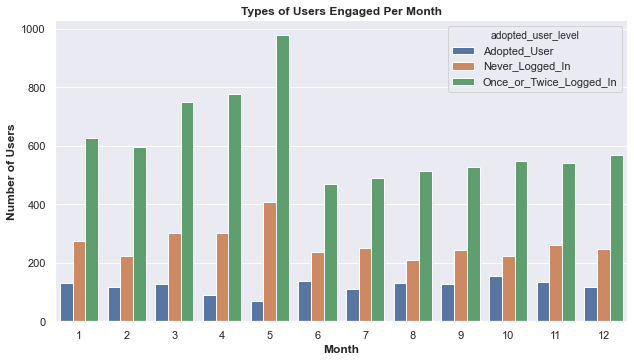

In [109]:
#sns.set(rc={'figure.figsize':(1,1)})
plt.figure(figsize=(10,8))
fg = sns.catplot(x='creation_month', y='count_of_users', hue='adopted_user_level', data=df_m, kind='bar', legend_out=False)
fg.fig.set_figwidth(10)
fg.fig.set_figheight(5)
plt.title("Types of Users Engaged Per Month", fontweight='bold')
plt.xlabel("Month", fontweight='bold')
plt.ylabel("Number of Users", fontweight='bold')

plt.savefig('bar_all_types_users_in_per_month.jpg')


In [41]:
df_adp_unq_with_eng.groupby(['creation_month','adopted_user_level']).agg({'adopted_user_level':'count'}).unstack('adopted_user_level')

adopted_user_level                                        
adopted_user_level       Adopted_User Never_Logged_In Once_or_Twice_Logged_In
creation_month                                                               
1                                 131             273                     625
2                                 117             222                     595
3                                 126             302                     749
4                                  89             302                     778
5                                  68             409                     978
6                                 137             236                     468
7                                 111             252                     489
8                                 131             208                     513
9                                 129             245                     527
10                                154             223                     547
11                                135             259                     542
12                                116             246                     568

In [42]:
#creating org_size column
org_id_size_dict=df_adp_unq_with_eng.groupby(['org_id'])['org_id'].count().to_dict()
df_adp_unq_with_eng['org_size']=df_adp_unq_with_eng['org_id'].map(org_id_size_dict)

In [43]:
df_adp_unq_with_eng['invited_by_a_user']=df_adp_unq_with_eng['invited_by_user_id'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [44]:
df_adp_unq_with_eng.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted_user_level,creation_hour,creation_month,org_size,invited_by_a_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0,Once_or_Twice_Logged_In,3,4,75,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,3.0,Adopted_User,3,11,233,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1.0,Once_or_Twice_Logged_In,23,3,32,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,Once_or_Twice_Logged_In,8,5,233,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0,Once_or_Twice_Logged_In,10,1,16,1


In [45]:
### PreProcessing for Model

In [46]:
df2=df_adp_unq_with_eng.drop(['last_session_creation_time', 'email','name','creation_time','user_id','org_id','visited','invited_by_user_id'],axis=1)

In [47]:
df2=col_transformed(df2,'creation_source')
df2=col_transformed(df2,'adopted_user_level')

In [48]:
# Separate majority and minority classes
df2_class0 = df2[df2.adopted_user_level==0] #minority class
df2_class1 = df2[df2.adopted_user_level==1] #in between
df2_class2 = df2[df2.adopted_user_level==2] #majority class


 
# Downsample class2
df_majority_downsampled = resample(df2_class2, 
                                 replace=False,    # sample without replacement
                                 n_samples=1444,     # to match minority class
                                 random_state=123) # reproducible results
df_inbetween_downsampled = resample(df2_class1, 
                                 replace=False,    # sample without replacement
                                 n_samples=1444,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine downsampled majority and inbetween class
df_downsampled = pd.concat([df_majority_downsampled, df_inbetween_downsampled])

# Combine minority class with df_downsampled

df2_downsampled=pd.concat([df_downsampled,df2_class0])
 
# Display new class counts
df2_downsampled.adopted_user_level.value_counts()


2    1444
1    1444
0    1444
Name: adopted_user_level, dtype: int64

In [49]:
df2_downsampled.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user_level,creation_hour,creation_month,org_size,invited_by_a_user
10247,2,0,0,2,13,6,48,0
9356,0,0,0,2,1,12,233,1
16,0,1,0,2,14,4,24,1
6794,2,0,0,2,22,5,19,0
726,1,0,0,2,2,7,168,1


In [50]:
y=df2_downsampled['adopted_user_level']

In [51]:
X=df2_downsampled.drop(['adopted_user_level'],axis=1)

In [52]:
X_train,X_test, y_train, y_test =train_test_split(X,y, random_state=0)

In [53]:
param_grid=[{'n_estimators':list(range(20,100,10))}]
gb=GradientBoostingClassifier()

gb_cv=GridSearchCV(gb,param_grid)
gb_cv.fit(X_train, y_train)

y_pred_gb=gb_cv.predict(X_test)

In [76]:
accuracy_score(y_test, y_pred_gb)

0.4792243767313019

In [77]:
gb_cv.best_score_, gb_cv.best_params_

(0.49123148038402287, {'n_estimators': 20})

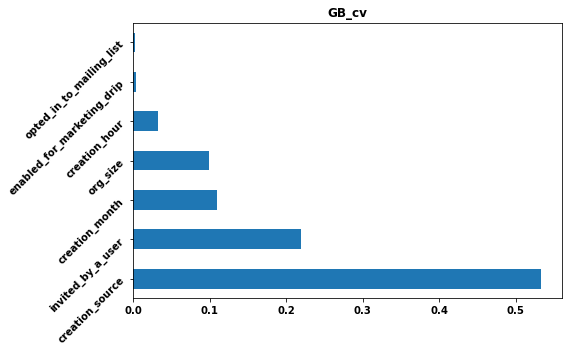

In [79]:
fig, axes=plt.subplots(1,1, figsize=(8,5))
feature_importance(gb_cv.best_estimator_, axes, 'GB_cv')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold',rotation=45)
plt.savefig('CM_GB_FeatureImp.jpg',pad_inches = 0)
plt.tight_layout()

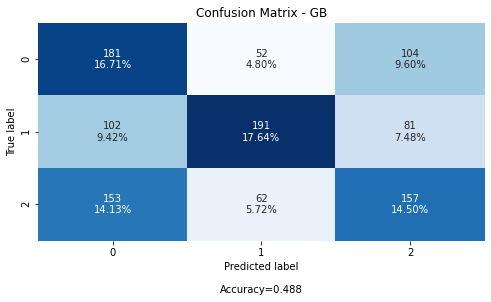

In [98]:
cm=confusion_matrix(y_test, y_pred_gb,  labels=[0, 1, 2])
cf.make_confusion_matrix(cm, figsize=(8,4), cbar=False, title='Confusion Matrix - GB')
plt.savefig('CM-GB.jpg', bbox_inches = "tight")
#Accuracy is sum of diagonal divided by total observations

In [134]:
prec_re(y_test,y_pred_gb, 'Gradient Boost')

,precision,recall,f-score,sample_size
0,0.42,0.54,0.47,337
1,0.63,0.51,0.56,374
2,0.46,0.42,0.44,372


In [96]:
### All the other models not used because their score is slightly worse then GB

In [82]:
param_grid = [
    {
    'n_estimators' : list(range(10,101,10)),
    'max_features': [5,4,2], 
    'max_depth'    : [2, 3, 5, 10],
    } 
]

RF=RandomForestClassifier()
RF_cv=GridSearchCV(RF, param_grid, cv=5)
RF_cv.fit(X_train, y_train)

y_pred_RF=RF_cv.predict(X_test)

In [94]:
accuracy_score(y_test, y_pred_RF)

0.47460757156048017

In [83]:
RF_cv.best_score_, RF_cv.best_params_

(0.5010800047410218, {'max_depth': 3, 'max_features': 4, 'n_estimators': 60})

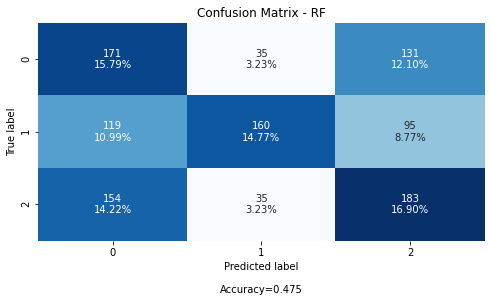

In [84]:
cm=confusion_matrix(y_test, y_pred_RF,  labels=[0, 1, 2])
cf.make_confusion_matrix(cm, figsize=(8,4), cbar=False, title='Confusion Matrix - RF')
#plt.savefig('CM-RF.jpg', bbox_inches = "tight")
#Accuracy is sum of diagonal divided by total observations

NameError: name 'RF_cv' is not defined

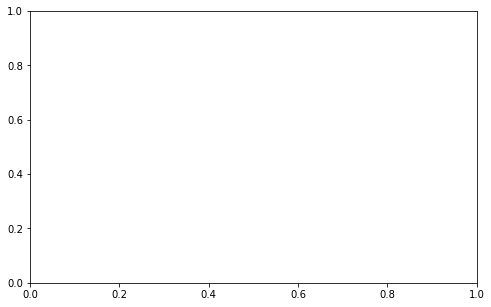

In [75]:
fig, axes=plt.subplots(1,1, figsize=(8,5))
feature_importance(RF_cv.best_estimator_, axes, 'RF_cv')
plt.tight_layout()

In [89]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_XG = xgb_model.predict(X_test)

In [95]:
accuracy_score(y_test, y_pred_XG)

0.46075715604801476

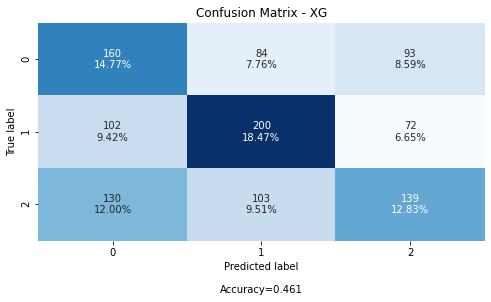

In [90]:
cm=confusion_matrix(y_test, y_pred_XG,  labels=[0, 1, 2])
cf.make_confusion_matrix(cm, figsize=(8,4), cbar=False, title='Confusion Matrix - XG')
#plt.savefig('CM-RF.jpg', bbox_inches = "tight")
#Accuracy is sum of diagonal divided by total observations